In [ ]:
import pandas as pd

data = pd.read_excel("GAIA IA v.1.2.xlsx")
data = data.drop(data.columns[0], axis=1)
mapping = {0: 'Al2O3', 1: 'Fe2O3', 2: '>63mm', 3: '>45mm', 4:'CS-C', 5: 'RMS', 6: 'A.A.', 7: 'Carbono', 8: 'L', 9: 'a', 10: '%'}
for i in range(11):
    data.rename(columns={data.columns[i]: mapping[i]+'.0'}, inplace=True)

In [287]:
actual_zeros = set()
total_zeros = 0
for i in range(len(data)):
    for j in range(len(mapping)-1):
        for k in range(7):
            if data.iloc[i, j+11*k] == 0 and data.iloc[i, 10+ 11*k] != 0:
                actual_zeros.add((i, j+11*k))

for col in data.columns:
    if col not in actual_zeros:
        data[col] = data[col].replace(0, 1e-10)
for i, j in actual_zeros:
    data.iloc[i, j] = 0

In [288]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
all_results = []

def train_data(X, y, shapeX, shapeY, nsize1, nsize2, lr, epochs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values.reshape(-1, shapeY), dtype=torch.float32) #1 ->4
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values.reshape(-1, shapeY), dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    class RegressionModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
            nn.Linear(shapeX, nsize1),
            nn.ReLU(),
            nn.Linear(nsize1, nsize2), 
            nn.ReLU(),
            nn.Linear(nsize2, shapeY)  
        )

        def forward(self, x):
            return self.net(x)

    model = RegressionModel()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_values = []

    for epochs in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        loss_values.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = criterion(predictions, y_test_tensor)
        mae = torch.mean(torch.abs(predictions - y_test_tensor))
        r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
        print(f"MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")
        
    return loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2

In [290]:
def plot_loss(loss_values):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

In [291]:
def plot_compare(predictions, y_test_tensor, tittle, targets):

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for i, ax in enumerate(axs.ravel()):
        if i >= len(targets):
            break
        actual = y_test_tensor[:, i].numpy()
        pred = predictions[:, i].numpy()
        ax.plot(actual, label='Actual', color='blue')
        ax.plot(pred, label='Predicted', linestyle='--', color='orange')
        ax.set_title(f'{targets[i]}: Actual vs Predicted')
        ax.set_ylabel(targets[i])
        ax.grid(True)
        ax.legend()

    for i in range(len(targets), len(axs.ravel())):
        fig.delaxes(axs.ravel()[i])
    fig.suptitle(f'Actual vs Predicted {tittle}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=5, features=''):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = nn.MSELoss()(predictions, y_test_tensor).item()
        mae = torch.mean(torch.abs(predictions - y_test_tensor)).item()        

    y_true = y_test_tensor.numpy().flatten()
    y_pred = predictions.numpy().flatten()

    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': y_pred - y_true
    })

    print(f"Evaluation Results:\n - MSE: {mse:.4f}\n - MAE: {mae:.4f} \n - R2: {r2.item():.4f}")
    print("\nExample predictions:")
    print(results_df.head(n))
    results = []
    results.append({
        'Model': features, 
        'MSE': mse,
        'MAE': mae,
        'R2': r2.item()
    })

    return pd.DataFrame(results)

In [293]:
target_names = ['Al2O3', 'Fe2O3', 'CS-C', 'Carbono']
y = data[['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']]
X = data.drop(columns=['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7'])
loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 200)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'All Features', target_names)
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features = 'All Features')
all_results.append(results)

MSE: 0.2733, MAE: 0.3105 R2: 0.9977


## NN for the first 3 raw materials


MSE: 1.5321, MAE: 0.6315 R2: 0.9869


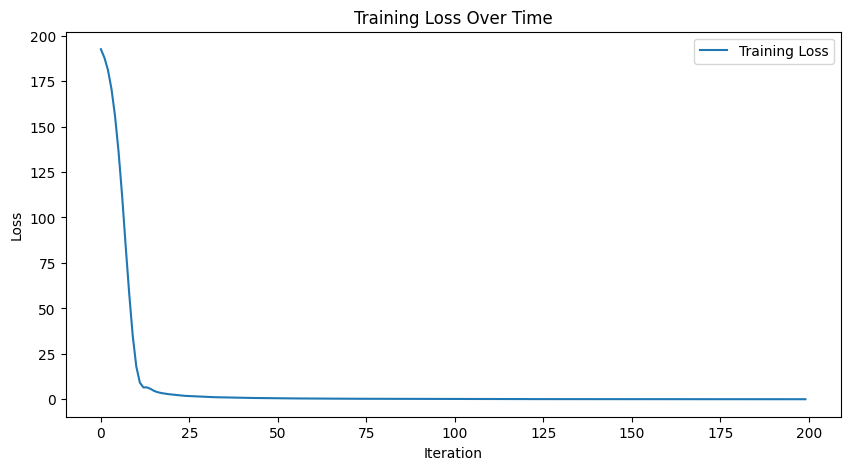

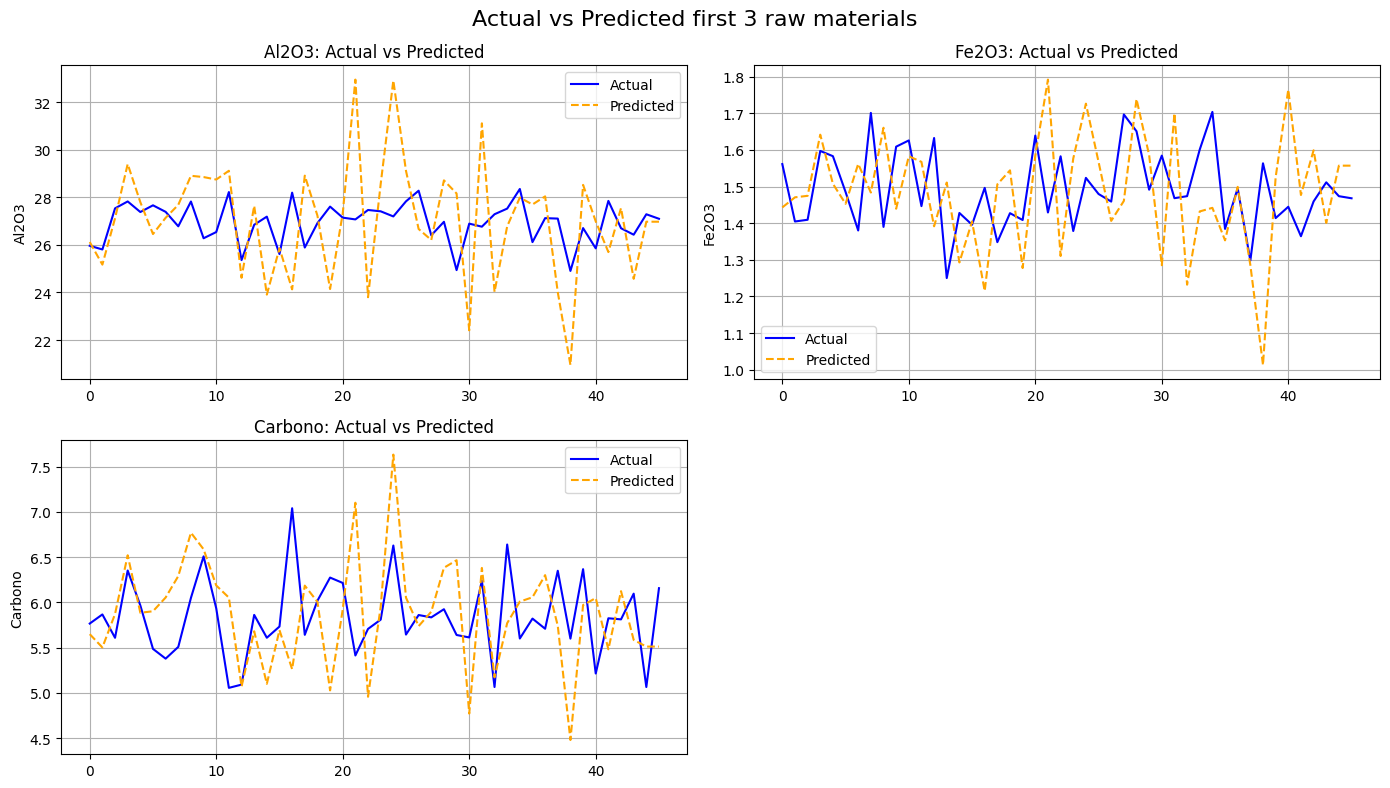

Evaluation Results:
 - MSE: 1.5321
 - MAE: 0.6315 
 - R2: 0.9869

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.118177  0.157490
1   1.561302   1.442985 -0.118317
2   5.767001   5.649918 -0.117084
3   0.010200   0.032696  0.022496
4  25.805275  25.169018 -0.636257
5   1.404642   1.470574  0.065933
6   5.867491   5.502808 -0.364683
7   0.113000   0.086079 -0.026921
8  27.533176  27.115072 -0.418104
9   1.409339   1.474676  0.065336


In [330]:
y = data[['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']]
X = data.iloc[:, :33]
loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 200)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'first 3 raw materials', target_names)
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='first 3 raw materials')
all_results.append(results)

## Predicting Al, Fe and Carbon using those features and their use %

In [ ]:
y = data[['Al2O3.7', 'Fe2O3.7', 'Carbono.7']]
X = data.filter(regex='^Al2O3|^Fe2O3|^Carbono|^%')
X = X.drop(columns=['Al2O3.7', 'Fe2O3.7', 'Carbono.7'])

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, 28, 3, 64, 32, 0.002, 200)
plot_loss(loss_values)
target_names = ['Al2O3', 'Fe2O3', 'Carbono']
plot_compare(predictions, y_test_tensor, 'Al2O3, Fe2O3 and Carbono', target_names)
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Al203, Fe203, Carbono and %')
all_results.append(results)

## Direct Features Prediction

MSE: 0.7052, MAE: 0.6125 R2: -0.0093


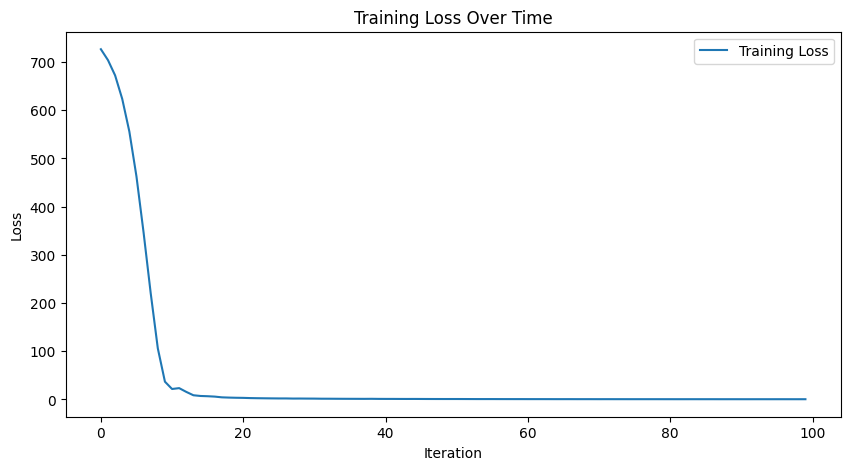

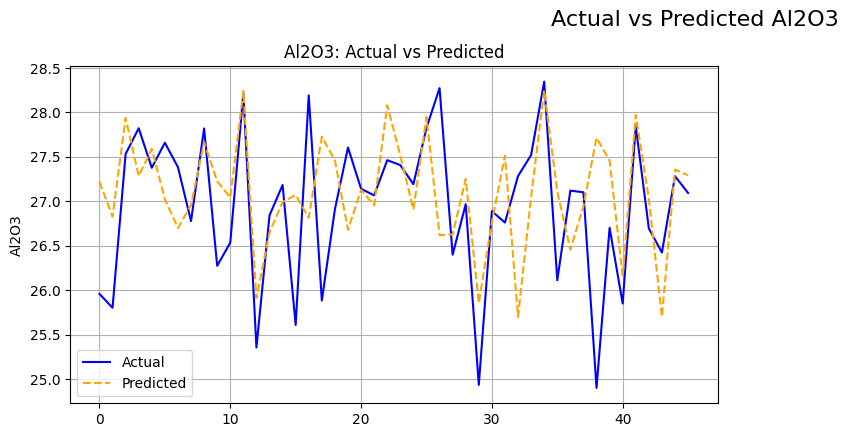

Evaluation Results:
 - MSE: 0.7052
 - MAE: 0.6125 
 - R2: -0.0093

Example predictions:
      Actual  Predicted     Error
0  25.960688  27.221041  1.260353
1  25.805275  26.829634  1.024359
2  27.533176  27.937611  0.404434
3  27.822983  27.285215 -0.537767
4  27.378498  27.590467  0.211969
5  27.660057  27.024755 -0.635302
6  27.385485  26.700314 -0.685171
7  26.778746  26.960907  0.182161
8  27.819937  27.664907 -0.155029
9  26.276518  27.225636  0.949118


In [327]:
y = data[['Al2O3.7']]
X = data.filter(regex='^Al2O3|^%')
X = X.drop(columns=['Al2O3.7'])

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'Al2O3', ['Al2O3'])
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Al203')
all_results.append(results)

MSE: 0.0144, MAE: 0.0965 R2: -0.2571


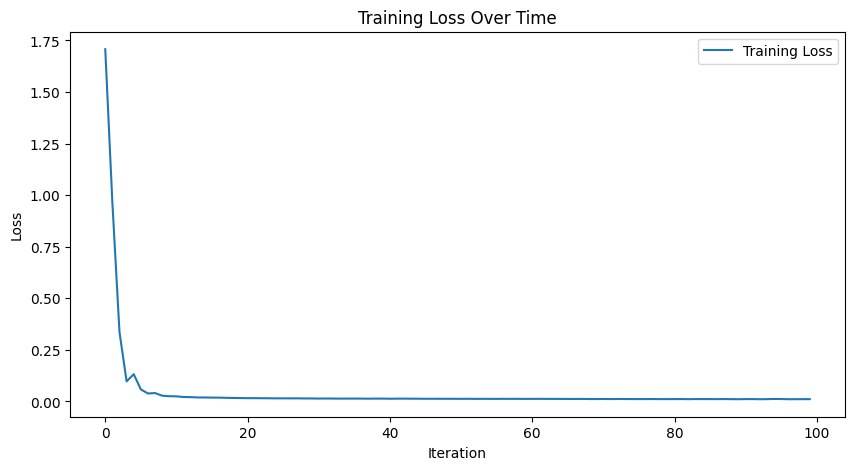

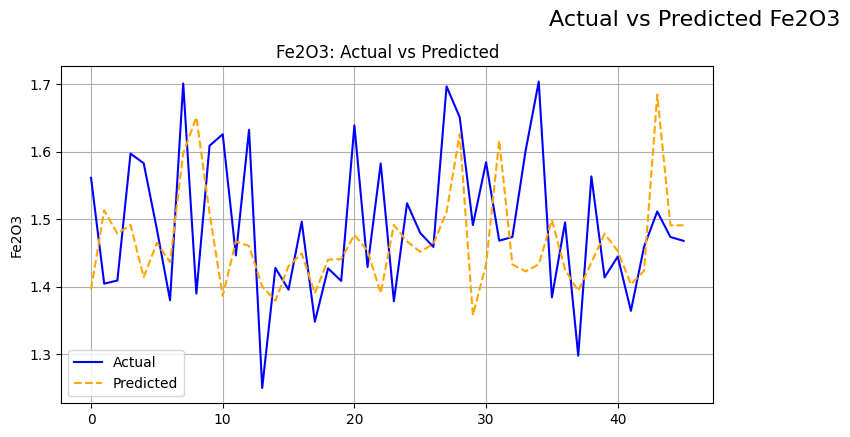

Evaluation Results:
 - MSE: 0.0144
 - MAE: 0.0965 
 - R2: -0.2571

Example predictions:
     Actual  Predicted     Error
0  1.561302   1.396250 -0.165052
1  1.404642   1.513275  0.108634
2  1.409339   1.478708  0.069369
3  1.597123   1.491711 -0.105412
4  1.582867   1.414323 -0.168544
5  1.485325   1.465032 -0.020293
6  1.380088   1.436572  0.056484
7  1.700930   1.597484 -0.103446
8  1.389911   1.651094  0.261183
9  1.608766   1.508862 -0.099905


In [310]:
y = data[['Fe2O3.7']]
X = data.filter(regex='^Fe2O3|^%')
X = X.drop(columns='Fe2O3.7')

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'Fe2O3', ['Fe2O3'])
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Fe203')
all_results.append(results)

MSE: 0.1759, MAE: 0.3477 R2: 0.0535


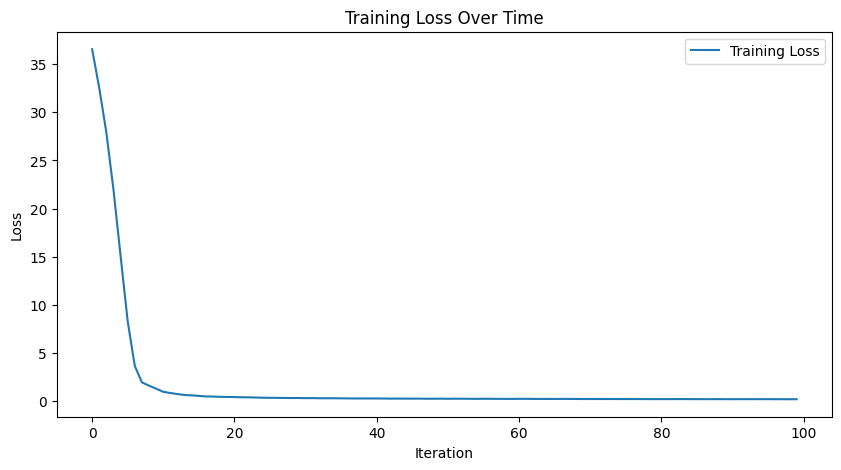

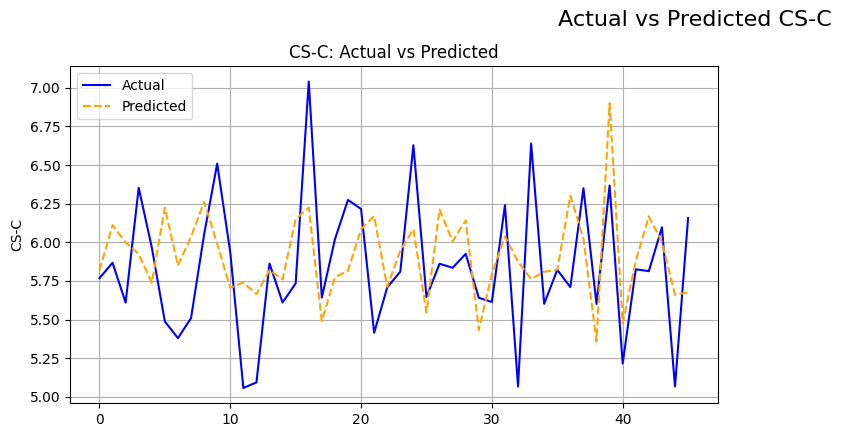

Evaluation Results:
 - MSE: 0.1759
 - MAE: 0.3477 
 - R2: 0.0535

Example predictions:
     Actual  Predicted     Error
0  5.767001   5.817317  0.050316
1  5.867491   6.110283  0.242792
2  5.609652   5.999745  0.390093
3  6.352685   5.923491 -0.429194
4  5.966827   5.737413 -0.229414
5  5.487041   6.224776  0.737735
6  5.379423   5.849458  0.470036
7  5.509121   6.035022  0.525901
8  6.050461   6.262386  0.211925
9  6.509033   5.991310 -0.517723


In [311]:
y = data[['CS-C.7']]
X = data.filter(regex='^CS-C|^%')
X = X.drop(columns='CS-C.7')

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'CS-C', ['CS-C'])
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='CS-C')
all_results.append(results)

MSE: 0.0020, MAE: 0.0313 R2: -0.0134


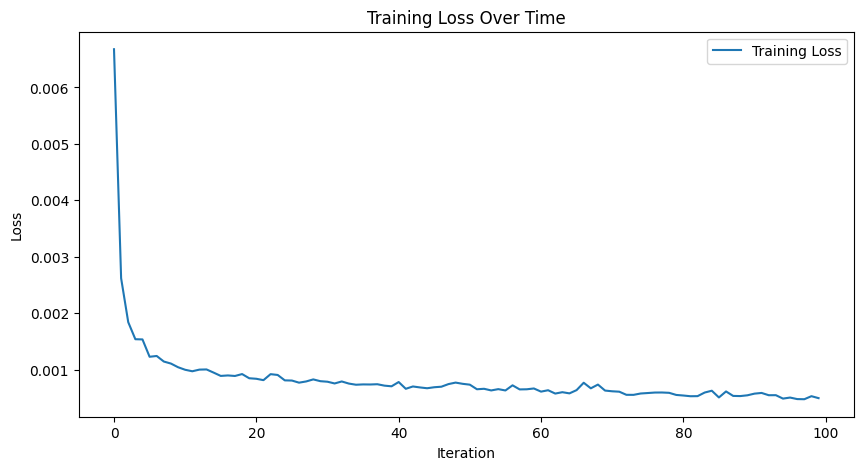

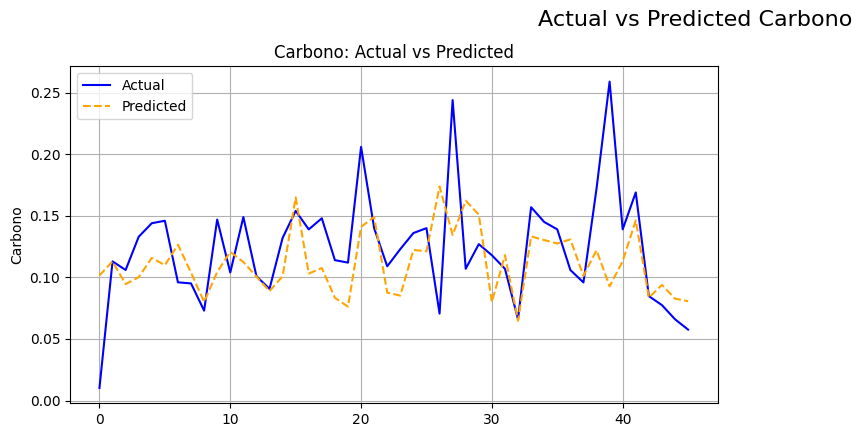

Evaluation Results:
 - MSE: 0.0020
 - MAE: 0.0313 
 - R2: -0.0134

Example predictions:
   Actual  Predicted     Error
0  0.0102   0.101598  0.091398
1  0.1130   0.112933 -0.000067
2  0.1060   0.094575 -0.011425
3  0.1330   0.100163 -0.032837
4  0.1440   0.115879 -0.028121
5  0.1460   0.109893 -0.036107
6  0.0960   0.126521  0.030521
7  0.0951   0.103903  0.008803
8  0.0730   0.080062  0.007062
9  0.1470   0.104404 -0.042596


In [312]:
y = data[['Carbono.7']]
X = data.filter(regex='^Carbono|^%')
X = X.drop(columns='Carbono.7')

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'Carbono', ['Carbono'])
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Carbono')
all_results.append(results)

## Final results

In [313]:
final_results_df = pd.concat(all_results, ignore_index=True)

print("\nFinal Results:")
from IPython.display import display
display(final_results_df)


Final Results:


,Model,MSE,MAE,R2
0,All Features,0.273332,0.310517,0.997661
1,first 3 raw materials,1.398433,0.640171,0.988032
2,"Al203, Fe203, Carbono and %",0.280260,0.277252,0.998160
3,Al203,0.639149,0.602715,0.085246
4,Fe203,0.014360,0.096510,-0.257137
5,CS-C,0.175892,0.347694,0.053472
6,Carbono,0.001977,0.031297,-0.013411


In [314]:
final_results_df = final_results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)
print("\nSorted Final Results:")
display(final_results_df)


Sorted Final Results:


,Model,MSE,MAE,R2
0,"Al203, Fe203, Carbono and %",0.280260,0.277252,0.998160
1,All Features,0.273332,0.310517,0.997661
2,first 3 raw materials,1.398433,0.640171,0.988032
3,Al203,0.639149,0.602715,0.085246
4,CS-C,0.175892,0.347694,0.053472
5,Carbono,0.001977,0.031297,-0.013411
6,Fe203,0.014360,0.096510,-0.257137
